This notebook outlines a comprehensive approach to training a financial transaction categorization model using a pre-trained transformer model (distilbert-base-uncased). By leveraging **local processing** and privacy-focused techniques, the sensitive nature of bank transaction data is securely maintained. This method addresses class imbalance through oversampling and utilizes robust evaluation metrics to monitor performance.

**Highlights**

*Sensitive Data Handling*: Utilizes local processing with Hugging Face libraries to ensure data privacy.

*Pre-trained Model*: Uses distilbert-base-uncased, benefiting from transfer learning for better performance on limited data.

*Class Imbalance Handling*: Employs oversampling techniques to balance the dataset effectively.

*Error Tracking*: Logs model errors to monitor and enhance accuracy over time.

**Limitations**

*Small Dataset Size*: The initial dataset contains only 300 rows, which may limit the model’s generalizability. This is because of the sensitive nature of bank transaction data. Finding good-quality open-source data is tough. I tried data augmentation techniques but conventional augmentation techqniques do not work because of the uniqueness of the bank data. 

*Overfitting Risk*: With a small dataset and a powerful model, there is a high risk of overfitting. Implementing more regularization techniques and careful monitoring of training and validation loss will help mitigate this issue.

I can overcome these limitations by periodically retraining the model with new data, you can ensure that the model stays up-to-date with any new patterns or trends in your transactions.

## Data Preparation and Oversampling
the section focuses on data preparation and handling class imbalance. It involves loading the dataset, extracting unique values, defining a sampling strategy, and performing oversampling to ensure balanced categories for model training.

Dataset is a very small dataset with only 300 trainable rows. The data is highly sensitive, so it is very hard to find an open-source large dataset. 

The sample model sequence would look like this:
{'Transaction note' + ':' + $ 'Amount'}

For example: 
POS Purchase FPOS Beer Store C45051: $13.97

In [2]:
# Import necessary libraries and load the dataset
import os
import pandas as pd
import numpy as np
import torch
import torch.cuda
from dotenv import load_dotenv
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import tqdm as notebook_tqdm

# Load the preprocessed dataset
p_df = pd.read_csv("transaction_data_feature_engineered (python).csv")
p_df.head(5)

,combined,big_amount,category,category_encoded
0,pos purchase opos presto autl toron: $-20.0,False,Public transport,11
1,pos purchase gpos hong's esso north: $-11.72,False,Ciggerates,4
2,miscellaneous payment transferwise canada_____...,True,Income,8
3,pos purchase gpos freshchoice ind etobi: $-23.21,False,Groceries,7
4,matchbox cannabis - ste north york on: $-34.21,False,Weed,18


Extracts unique values from the DataFrame columns `category` and `category_encoded` to create a mapping dictionary (`classification_labels`). It also calculates the frequency of each category and stores it in `category_count_dict

In [3]:
# Extract unique values for category and category_encoded
unique_values = p_df[['category', 'category_encoded']]
classification_labels = unique_values.set_index('category').to_dict()['category_encoded']

# Count the number of occurrences for each category
category_count_dict = p_df['category_encoded'].value_counts().to_dict()
print(category_count_dict)
classification_labels


{13: 46, 4: 41, 11: 32, 9: 29, 0: 20, 16: 20, 15: 17, 8: 16, 14: 16, 7: 13, 2: 13, 1: 12, 18: 11, 17: 6, 12: 6, 10: 6, 3: 5, 6: 4, 19: 2, 5: 2}


{'Public transport': 11,
 'Ciggerates': 4,
 'Income': 8,
 'Groceries': 7,
 'Weed': 18,
 'Restaurant, fast-food': 13,
 'Child Support': 3,
 'Interact': 9,
 'Charges, Fees': 2,
 'Unknown': 17,
 'Alcohol': 0,
 'Shopping': 14,
 'Wellness, beauty': 19,
 'Bill payments, Subscriptions': 1,
 'Rent': 12,
 'TRANSFER': 15,
 'Education, development': 6,
 'Phone, cell phone': 10,
 'Drug-store, chemist': 5,
 'Taxi': 16}

In [4]:
# Calculate the number of unique classification labels and load the access token
len_unique_labels = len(classification_labels)

print(len_unique_labels)

20


### Oversampling
Oversampling the dataset to address class imbalances within the dataset. A simple strategy was employed after doing some EDA in excel

In [5]:
# Define sampling strategy for oversampling

import math
sampling_strategy = {}
for key, value in category_count_dict.items():
    if value < 5:
        sampling_strategy[key] = round(value * 2.5)
    elif 5 <= value <= 14:
        sampling_strategy[key] = round(value * 1.5)
    else:
        sampling_strategy[key] = round(value)

print(sampling_strategy)

{13: 46, 4: 41, 11: 32, 9: 29, 0: 20, 16: 20, 15: 17, 8: 16, 14: 16, 7: 20, 2: 20, 1: 18, 18: 16, 17: 9, 12: 9, 10: 9, 3: 8, 6: 10, 19: 5, 5: 5}


In [6]:
# Perform oversampling to handle class imbalance
from imblearn.over_sampling import RandomOverSampler

X = p_df['combined']
X_reshaped = np.array(X).reshape(-1, 1)
y = p_df['category_encoded']
y_reshaped = np.array(y).reshape(-1, 1)
ros = RandomOverSampler(sampling_strategy=sampling_strategy)
X_resampled, y_resampled = ros.fit_resample(X=X_reshaped, y=y_reshaped)
from collections import Counter
resampled_counts = dict((Counter(y_resampled).items()))

In [7]:
# Defines a function to compare n number of dictionaries. 
# The function later is used to assess whether the class imbalance was addressed as per the sampling strategy
def compare_dictionaries(*dictionaries):
    """
    Compares multiple dictionaries and prints a side-by-side comparison table.

    Args:
        *dictionaries: A variable number of dictionaries to compare.

    Returns:
        None
    """
    # Get all keys from all dictionaries
    all_keys = set.union(*[set(d.keys()) for d in dictionaries])

    # Sort the keys
    sorted_keys = sorted(all_keys)

    # Print the table header
    print("{:<10} {:<10} {:<10} {}".format("Key", *[f"Dict {i+1}" for i in range(len(dictionaries))]))

    # Print each key-value pair for all dictionaries
    for key in sorted_keys:
        values = [d.get(key, None) for d in dictionaries]
        print("{:<10} {:<10} {:<10} {}".format(key, *values))

    # Check for same elements (order doesn't matter)
    if all(sorted(d.items()) == sorted(dictionaries[0].items()) for d in dictionaries[1:]):
        print("\nThe dictionaries contain the same elements (order may differ).")
    else:
        print("\nThe dictionaries contain different elements.")

compare_dictionaries(resampled_counts, sampling_strategy, category_count_dict)

Key        Dict 1     Dict 2     Dict 3
0          20         20         20
1          18         18         12
2          20         20         13
3          8          8          5
4          41         41         41
5          5          5          2
6          10         10         4
7          20         20         13
8          16         16         16
9          29         29         29
10         9          9          6
11         32         32         32
12         9          9          6
13         46         46         46
14         16         16         16
15         17         17         17
16         20         20         20
17         9          9          6
18         16         16         11
19         5          5          2

The dictionaries contain different elements.


## Model Preparation and Training

the section focuses on model preparation and training. It involves loading the pre-trained model and tokenizer, splitting and tokenizing the data, defining a custom Dataset class, freezing certain model layers, and setting up evaluation metrics.

The model of choice is distilbert base-uncased. The model was selected because it is a relatively small model compared to other open source model, with only 260 million parameters. The small model size can be leveraged for smaller hardware. Furthermore, since it was trained on open-source wikipedia data, it could help in identifying brand name tokens. For example, A token with *Beer Store* would be closer to *Alocohol* in the mappings of the model. 

--- 

In [8]:

load_dotenv() # Load environment variables
access_token = os.getenv("HUGGINGFACETOKEN")

# Load pre-trained model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=20)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", token=access_token)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The resampled data is split into training and testing sets with 10% of the data reserved for testing. The text data is then tokenized using the pre-trained tokenizer with padding and truncation to a maximum length. Test size was kept smaller because of the small size of the dataset

In [9]:
## Split data into training and testing sets
from sklearn.model_selection import train_test_split

# Set test size for splitting the data
test_size = 0.1

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(list(X_resampled), list(y_resampled), test_size=test_size, random_state=42)

# Extract text from the lists
X_train = [text[0] for text in X_train]
X_test = [text[0] for text in X_test]

# Tokenize the training and testing data
X_train_tokenized = tokenizer(X_train, padding="max_length", truncation=True)
X_test_tokenized = tokenizer(X_test, padding='max_length', truncation=True)

# Create DataFrame for training data (optional, for inspection)
x_train_df = pd.DataFrame(data={'text': X_train, 'labels': y_train})
x_train_df.head()

# Print a sample tokenized input for verification
print(X_train_tokenized['input_ids'][0])

[101, 29215, 5092, 1013, 10546, 1001, 6021, 2575, 2475, 3802, 16429, 11261, 3489, 2006, 1024, 1002, 1011, 3590, 1012, 5345, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [10]:
# Define a custom Dataset class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
# Create Dataset objects for training and testing data
train_dataset = Dataset(X_train_tokenized, y_train)
test_dataset = Dataset(X_test_tokenized, y_test)
train_dataset[5] #structure sample of the data

{'input_ids': tensor([  101, 11113,  2213, 10534,  1024,  1002,  1011,  2570,  1012,  1019,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

### Freezing Model Layers
Freezes the parameters of the first five layers of the DistilBERT model to prevent them from being updated during training. This can help in focusing the training on the later layers.

In [11]:
# Freeze the first few layers of the model
for layer in model.distilbert.transformer.layer[:5]:
    for param in layer.parameters():
        param.requires_grad = False

Defining the evaluation metrics in the following cell

In [12]:
# Define a function to compute evaluation metrics
def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred, average='macro')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

## Model Training and Testing

the notebook focuses on training and testing the model. It includes setting up training arguments, initializing the trainer, training the model, evaluating the model, and saving the trained model for future inference.

Sets up the training arguments and initializes the `Trainer` object with the model, datasets, tokenizer, and evaluation metrics. This configuration controls various aspects of the training process, such as the number of epochs, batch size, logging, and evaluation strategies.

In [52]:
'''Set up training arguments and initialize Trainer'''
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir='./output',  # Directory to store checkpoints and other training outputs
    overwrite_output_dir=True, 
    num_train_epochs=8,  # Number of training epochs
    per_device_train_batch_size=7,  # Batch size per device (GPU)
    save_total_limit=2,  # Keep only the last 2 checkpoints
    save_strategy='epoch',
    evaluation_strategy="epoch",  # Evaluation is done (and logged) every epoch
    logging_strategy="epoch", # Log every epoch
    logging_dir='./logs',  # Directory to store logs
    lr_scheduler_type="linear", # Learning rate scheduler type
    metric_for_best_model = 'f1',
    load_best_model_at_end=True     
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [53]:
'''
Clear CUDA cache and check device information Clears the CUDA cache to free up GPU memory and prints the current device information. 
This step ensures that the GPU is properly utilized and helps in debugging device-related issues.
'''
torch.cuda.empty_cache()

# Print device information
print(trainer.args.device)
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

cuda:0
0
NVIDIA GeForce RTX 2050


In [54]:
# Train the model
trainer.train()
## train_result = trainer.train()

 12%|█▎        | 47/376 [00:27<03:10,  1.73it/s]

{'loss': 1.4473, 'grad_norm': 6.444355487823486, 'learning_rate': 4.375e-05, 'epoch': 1.0}


e:\Data analytics projects\Financial Tracker copy\FinTrackerenv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Data analytics projects\Financial Tracker copy\FinTrackerenv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

 12%|█▎        | 47/376 [00:29<03:10,  1.73it/s]

<class 'transformers.trainer_utils.EvalPrediction'>
{'eval_loss': 1.4107167720794678, 'eval_accuracy': 0.5945945945945946, 'eval_precision': 0.5604166666666667, 'eval_recall': 0.5354166666666667, 'eval_f1': 0.4985119047619047, 'eval_runtime': 1.6156, 'eval_samples_per_second': 22.902, 'eval_steps_per_second': 3.095, 'epoch': 1.0}


 25%|██▌       | 94/376 [00:57<02:43,  1.73it/s]

{'loss': 1.0984, 'grad_norm': 6.229363918304443, 'learning_rate': 3.7500000000000003e-05, 'epoch': 2.0}


e:\Data analytics projects\Financial Tracker copy\FinTrackerenv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Data analytics projects\Financial Tracker copy\FinTrackerenv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

 25%|██▌       | 94/376 [00:59<02:43,  1.73it/s]

<class 'transformers.trainer_utils.EvalPrediction'>
{'eval_loss': 1.2250162363052368, 'eval_accuracy': 0.6216216216216216, 'eval_precision': 0.5239583333333333, 'eval_recall': 0.5447916666666666, 'eval_f1': 0.4905257936507937, 'eval_runtime': 1.6064, 'eval_samples_per_second': 23.033, 'eval_steps_per_second': 3.113, 'epoch': 2.0}


 38%|███▊      | 141/376 [01:27<02:15,  1.73it/s]

{'loss': 0.8482, 'grad_norm': 4.963200092315674, 'learning_rate': 3.125e-05, 'epoch': 3.0}


e:\Data analytics projects\Financial Tracker copy\FinTrackerenv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Data analytics projects\Financial Tracker copy\FinTrackerenv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

 38%|███▊      | 141/376 [01:29<02:15,  1.73it/s]

<class 'transformers.trainer_utils.EvalPrediction'>
{'eval_loss': 1.0520339012145996, 'eval_accuracy': 0.7027027027027027, 'eval_precision': 0.60625, 'eval_recall': 0.6124999999999999, 'eval_f1': 0.5822420634920635, 'eval_runtime': 1.6159, 'eval_samples_per_second': 22.898, 'eval_steps_per_second': 3.094, 'epoch': 3.0}


 50%|█████     | 188/376 [01:57<01:49,  1.71it/s]

{'loss': 0.6952, 'grad_norm': 3.7948412895202637, 'learning_rate': 2.5e-05, 'epoch': 4.0}


e:\Data analytics projects\Financial Tracker copy\FinTrackerenv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Data analytics projects\Financial Tracker copy\FinTrackerenv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

 50%|█████     | 188/376 [01:59<01:49,  1.71it/s]

<class 'transformers.trainer_utils.EvalPrediction'>
{'eval_loss': 0.9389117360115051, 'eval_accuracy': 0.7027027027027027, 'eval_precision': 0.60625, 'eval_recall': 0.6124999999999999, 'eval_f1': 0.5822420634920635, 'eval_runtime': 1.5964, 'eval_samples_per_second': 23.176, 'eval_steps_per_second': 3.132, 'epoch': 4.0}


 62%|██████▎   | 235/376 [02:27<01:22,  1.72it/s]

{'loss': 0.589, 'grad_norm': 6.632248401641846, 'learning_rate': 1.8750000000000002e-05, 'epoch': 5.0}


e:\Data analytics projects\Financial Tracker copy\FinTrackerenv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Data analytics projects\Financial Tracker copy\FinTrackerenv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

 62%|██████▎   | 235/376 [02:28<01:22,  1.72it/s]

<class 'transformers.trainer_utils.EvalPrediction'>
{'eval_loss': 0.8875190019607544, 'eval_accuracy': 0.7027027027027027, 'eval_precision': 0.60625, 'eval_recall': 0.6124999999999999, 'eval_f1': 0.5822420634920635, 'eval_runtime': 1.5955, 'eval_samples_per_second': 23.19, 'eval_steps_per_second': 3.134, 'epoch': 5.0}


 75%|███████▌  | 282/376 [02:57<00:54,  1.72it/s]

{'loss': 0.5211, 'grad_norm': 6.7500996589660645, 'learning_rate': 1.25e-05, 'epoch': 6.0}


e:\Data analytics projects\Financial Tracker copy\FinTrackerenv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Data analytics projects\Financial Tracker copy\FinTrackerenv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

 75%|███████▌  | 282/376 [02:58<00:54,  1.72it/s]

<class 'transformers.trainer_utils.EvalPrediction'>
{'eval_loss': 0.8410699963569641, 'eval_accuracy': 0.7297297297297297, 'eval_precision': 0.6215277777777778, 'eval_recall': 0.625, 'eval_f1': 0.5988782051282051, 'eval_runtime': 1.596, 'eval_samples_per_second': 23.183, 'eval_steps_per_second': 3.133, 'epoch': 6.0}


 88%|████████▊ | 329/376 [03:27<00:27,  1.72it/s]

{'loss': 0.4548, 'grad_norm': 7.527724742889404, 'learning_rate': 6.25e-06, 'epoch': 7.0}


e:\Data analytics projects\Financial Tracker copy\FinTrackerenv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Data analytics projects\Financial Tracker copy\FinTrackerenv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

 88%|████████▊ | 329/376 [03:29<00:27,  1.72it/s]

<class 'transformers.trainer_utils.EvalPrediction'>
{'eval_loss': 0.7941811680793762, 'eval_accuracy': 0.7567567567567568, 'eval_precision': 0.7444444444444445, 'eval_recall': 0.6645833333333333, 'eval_f1': 0.6662393162393162, 'eval_runtime': 1.6125, 'eval_samples_per_second': 22.945, 'eval_steps_per_second': 3.101, 'epoch': 7.0}


100%|██████████| 376/376 [03:57<00:00,  1.72it/s]

{'loss': 0.426, 'grad_norm': 3.857321262359619, 'learning_rate': 0.0, 'epoch': 8.0}


e:\Data analytics projects\Financial Tracker copy\FinTrackerenv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Data analytics projects\Financial Tracker copy\FinTrackerenv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

100%|██████████| 376/376 [03:59<00:00,  1.72it/s]

<class 'transformers.trainer_utils.EvalPrediction'>
{'eval_loss': 0.7974675893783569, 'eval_accuracy': 0.7567567567567568, 'eval_precision': 0.7444444444444445, 'eval_recall': 0.6645833333333333, 'eval_f1': 0.6662393162393162, 'eval_runtime': 1.5921, 'eval_samples_per_second': 23.24, 'eval_steps_per_second': 3.14, 'epoch': 8.0}


100%|██████████| 376/376 [04:00<00:00,  1.57it/s]

{'train_runtime': 240.0063, 'train_samples_per_second': 10.966, 'train_steps_per_second': 1.567, 'train_loss': 0.7599966526031494, 'epoch': 8.0}


TrainOutput(global_step=376, training_loss=0.7599966526031494, metrics={'train_runtime': 240.0063, 'train_samples_per_second': 10.966, 'train_steps_per_second': 1.567, 'train_loss': 0.7599966526031494, 'epoch': 8.0})

In [55]:
trainer.evaluate()

100%|██████████| 5/5 [00:01<00:00,  4.45it/s]e:\Data analytics projects\Financial Tracker copy\FinTrackerenv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Data analytics projects\Financial Tracker copy\FinTrackerenv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 5/5 [00:01<00:00,  4.37it/s]

<class 'transformers.trainer_utils.EvalPrediction'>


{'eval_loss': 0.7941811680793762,
 'eval_accuracy': 0.7567567567567568,
 'eval_precision': 0.7444444444444445,
 'eval_recall': 0.6645833333333333,
 'eval_f1': 0.6662393162393162,
 'eval_runtime': 1.7589,
 'eval_samples_per_second': 21.036,
 'eval_steps_per_second': 2.843,
 'epoch': 8.0}

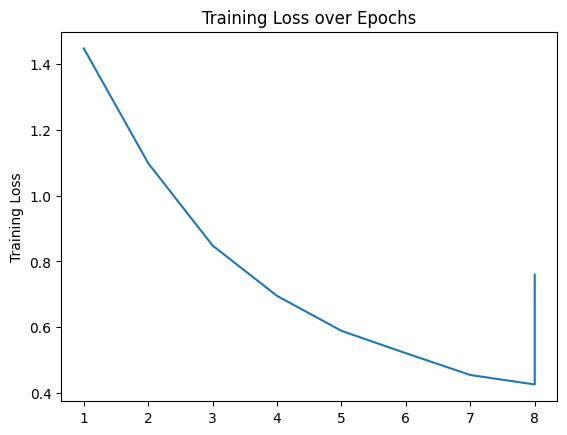

In [81]:
# This block will be used to plot the training loss 
# It iterates through the trainer.state.log_history and appends the losses and epochs to lists.

import matplotlib.pyplot as plt  # Import for plotting (assuming correct installation)


training_loss = []
epoch = []
for x in range(len(trainer.state.log_history)):
    if x%2 == 0:
        try:
            dummy = trainer.state.log_history[x]['loss']
            dummy_2 = trainer.state.log_history[x]['epoch']
        except KeyError:  # Handle potential absence of 'loss' key
            try:
                dummy = trainer.state.log_history[x]['train_loss']  # Try 'eval_loss' if 'loss' is missing
            except KeyError:
                print(f"Warning: 'loss' or 'eval_loss' key not found in log_history[{x}]")
                # Handle missing key gracefully (e.g., continue or skip the iteration)
        training_loss.append(dummy)
        epoch.append(dummy_2)

# Assuming you have data to plot:
plt.plot(epoch, training_loss)
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [85]:
'''Save the trained model and test inference'''

from transformers import pipeline

## metrics = train_result.metrics

# Save the model to the specified directory

trainer.save_model(r"E:\Data analytics projects\Financial Tracker\Model training\Finance_categorization_fine_tuned")
## trainer.log_metrics("train", metrics)
## trainer.save_metrics("train", metrics)

# Load the saved model for inference
model_2 = AutoModelForSequenceClassification.from_pretrained(r"E:\Data analytics projects\Financial Tracker\Model training\Finance_categorization_fine_tuned")

# Define a text for classification
text = "POS Purchase FPOS SHELL C45051: $13.97"

# Initialize the pipeline for text classification
pipe = pipeline("text-classification", model=model_2, tokenizer=tokenizer)

# Perform inference
result = pipe(text)
print(result)


[{'label': 'LABEL_4', 'score': 0.9091681241989136}]


In [28]:
classification_labels

{'Public transport': 11,
 'Ciggerates': 4,
 'Income': 8,
 'Groceries': 7,
 'Weed': 18,
 'Restaurant, fast-food': 13,
 'Child Support': 3,
 'Interact': 9,
 'Charges, Fees': 2,
 'Unknown': 17,
 'Alcohol': 0,
 'Shopping': 14,
 'Wellness, beauty': 19,
 'Bill payments, Subscriptions': 1,
 'Rent': 12,
 'TRANSFER': 15,
 'Education, development': 6,
 'Phone, cell phone': 10,
 'Drug-store, chemist': 5,
 'Taxi': 16}